In [39]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

In [40]:
class BondExpansionEstimator(nn.Module):
    def __init__(self, input_size, hidden_layers, check_weights = True):
        super(BondExpansionEstimator, self).__init__()
        self.input_size = input_size
        self.hidden_layers = hidden_layers
        self.check_weights = check_weights
        self.hidden1 = nn.Linear(input_size, hidden_layers[0])
        self.hidden2 = nn.Linear(input_size, hidden_layers[1])
        self.hidden3 = nn.Linear(hidden_layers[0], 1)

    def forward(self, x):
        # Select data related to individual bonds
        # Data- 2D   seq x feat
        seq_len = x.shape[0]
        bond_data = x[:, 0:-1]
        bond_data = bond_data.view(-1, self.input_size)
        # Assume last column of data is bond weight (fraction of volume)
        vol_fracs = x[:, -1]
        # Check the bond weights are well normalized
        if self.check_weights:
            assert torch.abs(torch.sum(vol_fracs) - 1) < 1e-5 
        
        # Run all hidden layers
        out = torch.relu(self.hidden1(bond_data))
        out = torch.relu(self.hidden2(bond_data))
        out = self.hidden3(out)
        out = out.view(-1, seq_len)
        # Sum all bonds according to their bond fractions
        summed = torch.sum(out*vol_fracs)
        return summed

class LatticeDistortionEstimator(nn.Module):
    def __init__(self, input_size):
        super(LatticeDistortionEstimator, self).__init__()
        self.input_size = input_size
        self.layer1 = nn.Linear(input_size, 1)

    def forward(self, x):
        # Run all hidden layers
        out = torch.tanh(self.layer1(x))

        return out

class CombinedModel(nn.Module):
    def __init__(self, model_a, model_b):
        super(CombinedModel, self).__init__()
        self.model_a = model_a
        self.model_b = model_b

    def forward(self, x1, x2):
        output_a = self.model_a(x1)
        output_b = self.model_b(x2)

        return output_a*output_b


## Test Use of Model with Fake Data

In [3]:
# Model Parameters
bond_input_size = 48
distortion_input_size = 4
hidden_layers = [20, 20]

# Training Parameters
learning_rate = 0.0001
num_epochs = 50

# Create an instance of the AdditiveSequentialModel
expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers, check_weights=False)
distortion_model = LatticeDistortionEstimator(distortion_input_size)
tec_model = CombinedModel(expansion_model, distortion_model)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(tec_model.parameters(), lr=learning_rate)  # That's me!!
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))

# Generate random sequential data for training
data_size = 1500
seq_length = 5
test_bond_fracs = 0.3*torch.rand(data_size, seq_length, 1)
input_data1 = torch.rand(data_size, seq_length, bond_input_size)
input_data2 = torch.rand(data_size, distortion_input_size)+1
target_data =  2*torch.randn(data_size, 1)  # Start with noise
hidden_A = torch.rand(bond_input_size, 1) # Hidden model
hidden_B = torch.rand(distortion_input_size, 1) # Hidden model
perfect_lab = torch.ones(data_size, 1)  # Start with noise
for i in range(len(target_data)):
    target_data[i] = target_data[i] + torch.matmul( torch.matmul(input_data1[i,:,:], hidden_A).T, test_bond_fracs[i,:]) * torch.matmul(input_data2[i,:], hidden_B)
    perfect_lab[i] = torch.matmul( torch.matmul(input_data1[i,:,:], hidden_A).T, test_bond_fracs[i,:]) * torch.matmul(input_data2[i,:], hidden_B)
input_data1 = torch.cat((input_data1, test_bond_fracs), dim=2)

# Training loop
loss_log = []
for epoch in range(num_epochs):
    # Forward pass
    losses = []
    for in1, in2, y in zip(input_data1, input_data2, target_data):
        outputs = tec_model(in1, in2)
        loss = criterion(outputs, y)
    
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example of using the trained model for prediction
test_input1 = torch.randn(1, seq_length, bond_input_size+1)
test_input2 = torch.randn(1, distortion_input_size)
predicted_output = torch.zeros(data_size, 1)
for i in range(data_size):
    predicted_output[i] = tec_model(input_data1[i], input_data2[i])

Number of parameters:  1986
Epoch [10/50], Loss: 1386.0701
Epoch [20/50], Loss: 1385.9746
Epoch [30/50], Loss: 1385.9740
Epoch [40/50], Loss: 1385.9740
Epoch [50/50], Loss: 1385.9740


Input1 shape: torch.Size([1, 5, 49])
Input2 shape: torch.Size([1, 4])


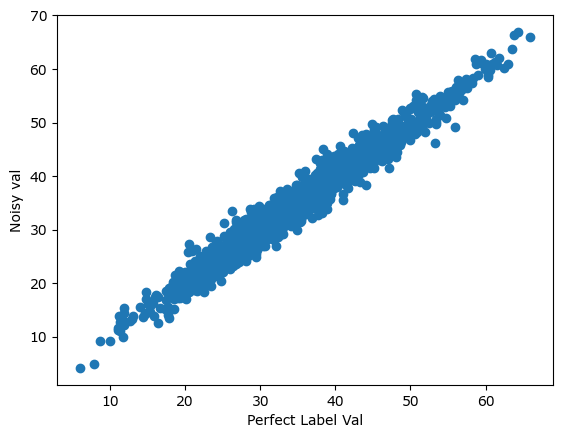

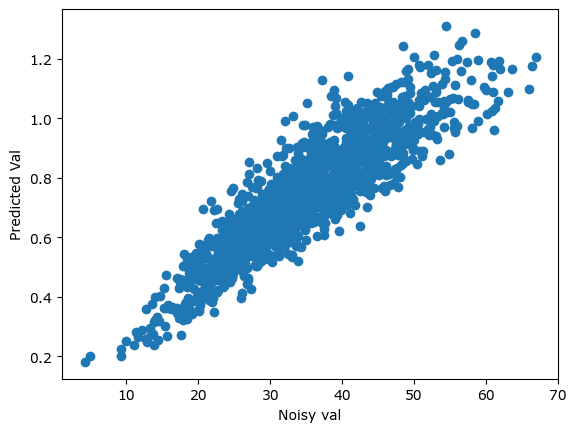

In [4]:
# Results
print("Input1 shape:", test_input1.shape)
print("Input2 shape:", test_input2.shape)

plt.scatter(perfect_lab.numpy(), target_data.numpy())
plt.ylabel("Noisy val")
plt.xlabel("Perfect Label Val")
plt.show()

plt.scatter(target_data.numpy(), predicted_output.detach().numpy())
plt.xlabel("Noisy val")
plt.ylabel("Predicted Val")
plt.show()


## Now Train on Real Data with SGD

## Load in Data

In [41]:
labels_df = pd.read_csv("labels/labels_reduced.csv", index_col=0)
features_bond_df = pd.read_csv("features/features_bond.csv", index_col=0)
features_struc_df = pd.read_csv("features/features_structure.csv", index_col=0)

# Choose Features
columns_all = features_bond_df.columns[2:-1].to_list()  # ALL FEATURES, exclude file names and bond volume fractions
feature_weights = features_bond_df[features_bond_df.columns[-1]].to_numpy()
struc_columns = features_struc_df.columns[2:].to_list()

# Copy over labels to each bond (just for correlation)
y = list()
combined_data = list()
weights = list()
struc_data = list()
labels_skipped = 0
max_length = 0
all_phases = set()
for idx in labels_df.index:
    phase = labels_df.loc[idx, 'phase_id']
    feat = features_bond_df[features_bond_df['structure_name'] == str(int(phase))+'_super.cif']  # Select all rows applicable to 
    feat_struc = features_struc_df[features_struc_df['structure_name'] == str(int(phase))+'_super.cif']
    if len(feat) > 0 and len(feat_struc) > 0:
        weights.append(torch.Tensor(feat['volume_fraction'].values).to(torch.float).view(len(feat),1))
        feat = feat[columns_all]
        feat['temperature'] = labels_df.loc[idx, "temperature"]  # add temperature as a feature
        max_length = max(max_length, len(feat))
        combined_data.append(torch.Tensor(feat.values).to(torch.float))
        feat_struc = feat_struc[struc_columns]
        try:
            struc_data.append(torch.Tensor(feat_struc.values).to(torch.float))
        except:
            print(feat_struc.values)
        y.append( labels_df.loc[idx, "thermal_expansion"] )
        all_phases.add(phase)
    else:
        print("Phases ", phase, " not found in features data")
        labels_skipped += 1

print("Total Number of Labels: ", len(y))
print("Skipped {} structures".format(labels_skipped))
print("Total Unique structures", len(all_phases))
print("Max Number of Bonds: ", max_length)
# Recast y as a torch tensor
y = torch.Tensor(y)
y = y.view(-1,1)

Phases  13996.0  not found in features data
Phases  131156.0  not found in features data
Phases  130566.0  not found in features data
Phases  71777.0  not found in features data
Phases  71777.0  not found in features data
Phases  71776.0  not found in features data
Phases  71776.0  not found in features data
Phases  142888.0  not found in features data
Phases  127780.0  not found in features data
Phases  122321.0  not found in features data
Phases  59916.0  not found in features data
Phases  9782.0  not found in features data
Phases  12354.0  not found in features data
Phases  70111.0  not found in features data
Phases  70110.0  not found in features data
Phases  70180.0  not found in features data
Phases  70109.0  not found in features data
Phases  70109.0  not found in features data
Phases  77642.0  not found in features data
Phases  128280.0  not found in features data
Phases  70179.0  not found in features data
Phases  15966.0  not found in features data
Phases  15933.0  not found 

In [42]:
# Make sure all weights are normalized
# TODO: figure out why this is necessary
for i in range(len(weights)):
    s = torch.sum(weights[i])
    if abs(s-1) > 1e-6:
        weights[i] = weights[i]/s

In [43]:
# Build and Normalize X
X_mean = torch.mean(torch.cat(combined_data),dim=0)
X_std = torch.std(torch.cat(combined_data),dim=0)
X = []
for x,w in zip(combined_data, weights):
    X.append(torch.cat(((x-X_mean)/X_std, w), dim=1))

In [44]:
# Build and Normalize X_struc
X_struc_mean = torch.mean(torch.cat(struc_data),dim=0)
X_struc_std = torch.std(torch.cat(struc_data),dim=0)
X_struc = []
for x in struc_data:
    X_struc.append(torch.Tensor((x-X_struc_mean)/X_struc_std) )
X_struc = torch.cat(X_struc)

In [45]:
# Normalize Y
y_mean = torch.mean(y)
y_std = torch.std(y)
y = (y-y_mean)/y_std

In [46]:
y_std

tensor(7.4929)

In [47]:
y_mean

tensor(10.2382)

In [48]:
# Save tensors to a file
torch.save({'X': X, 'y': y, 'X_struc': X_struc, 'X_mean':X_mean, 'X_std':X_std, 'X_struc_mean':X_struc_mean, 'X_struc_std':X_struc_std,'y_mean':y_mean, 'y_std':y_std}, 'features/data_tensors.pth')

## Create and Train Model

In [137]:
# Load tensors from the file
loaded_data = torch.load('features/data_tensors.pth')
X = loaded_data['X']
X_struc = loaded_data['X_struc']
y = loaded_data['y']

# Load Preprocessing Parameters
X_mean = loaded_data['X_mean']
X_std = loaded_data['X_std']
X_struc_mean = loaded_data['X_struc_mean']
X_struc_std = loaded_data['X_struc_std']
y_mean = loaded_data['y_mean']
y_std = loaded_data['y_std']
print("Number labels:", len(y))

num_bonds = 0
for x in X:
    num_bonds += len(x)
print("Total Number of Bonds: ", num_bonds)

Number labels: 1068
Total Number of Bonds:  3385536


In [138]:
# Model Parameters
bond_input_size = len(X[0][0])-1  # Don't count bond length weights
distortion_input_size = len(X_struc[0])
hidden_layers = [30, 30]

# Training Parameters
learning_rate = 0.0005
num_epochs = 400000
batch_size = 1  # True SGD due to data being varying length sequences
n_splits = 10
break_early = True
score_n_it = 1000  # Score every N epochs

# Set up Cross Validation with K-Folds
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Check GPU Availability
if torch.cuda.is_available():
    print("Available GPU Device:", torch.cuda.get_device_name(0))
else: 
    print("GPU not available, using CPU...")


Available GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU


## Perform k-fold cross-validation

In [139]:
def score_data(model, X_bond, X_struc, y):
    model.eval()
    with torch.no_grad():
        y_pred = []
        for x, x_struc in zip(X_bond, X_struc):
            if torch.cuda.is_available():
                x, x_struc = x.to('cuda'), x_struc.to('cuda')
            y_pred.append(model(x, x_struc).cpu())
        y_pred = torch.cat(y_pred)

    metric1 = mean_squared_error(y.numpy(), y_pred.numpy())
    metric2 = mean_absolute_error(y.numpy(), y_pred.numpy())
    metric3 = r2_score(y.numpy(), y_pred.numpy())
    metric4 = np.var(np.abs(y.numpy(), y_pred.numpy()))
    
    return [metric1, metric2, metric3, metric4]

In [ ]:
loss_log = list()
train_scores = list()
test_scores = list()
fold_num = 0  # Tracking current fold

for train_index, test_index in kf.split(X):
    train_index = list(train_index)
    test_index = list(test_index)
    train_scores.append([])
    test_scores.append([])
    fold_num += 1
    
    # Create an instance of the model
    expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers)
    distortion_model = LatticeDistortionEstimator(distortion_input_size)
    tec_model = CombinedModel(expansion_model, distortion_model)
    
    # Define a loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(expansion_model.parameters(), lr=learning_rate)  # That's me!!
    
    # Train on GPU
    if torch.cuda.is_available():
        tec_model = tec_model.to('cuda') 
    
    print("Starting K Fold {} out of {}".format(fold_num, n_splits))
    # Training loop
    losses = list()
    for epoch in range(num_epochs):
        # Sample one data point for SGD
        train_idx = random.choice(train_index)
        
        # Move training to GPU if available
        if torch.cuda.is_available():
            batch_X, batch_X_struc, batch_y = X[train_idx].to('cuda'), X_struc[train_idx].to('cuda'), y[train_idx].to('cuda')
        else:
            batch_X, batch_X_struc, batch_y = X[train_idx], X_struc[train_idx], y[train_idx]

        # Forward pass
        outputs = tec_model(batch_X, batch_X_struc)  
        loss = criterion(outputs, batch_y)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record loss to make convergence plots
        losses.append(loss.item())
        
        # Evaluate score every N epochs
        if (epoch + 1) % score_n_it == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses[-1000:]):.4f}')
            train_metrics = score_data(tec_model, [X[i] for i in train_index], [X_struc[i] for i in train_index], torch.cat([y[i] for i in train_index]))
            train_scores[-1].append(train_metrics)
            test_metrics = score_data(tec_model, [X[i] for i in test_index], [X_struc[i] for i in test_index], torch.cat([y[i] for i in test_index]))
            test_scores[-1].append(test_metrics)
            
    loss_log.append(losses)

    # Clear cache on GPU
    torch.cuda.empty_cache() 
    
    # If you only want to run once for speed
    if break_early:
        break
 

Starting K Fold 1 out of 10
Epoch [1000/400000], Loss: 1.0018
Epoch [2000/400000], Loss: 0.8033


In [ ]:
# Report Number of Parameters
print("Number of parameters: ", sum(p.numel() for p in tec_model.parameters()))
n_sel = 245
# Calculate the average performance across all folds
train_scores = np.array(train_scores)
print("TRAINING R2: ", np.mean(train_scores[:,n_sel,2]))
print("TRAINING Mean Error [10-6/K]: ", np.mean(train_scores[:,n_sel,1])*y_std.numpy())
print("TRAINING Error Variance [10-6/K]: ", np.mean(train_scores[:,n_sel,3]*y_std.numpy()))
print("TRAINING MSE [10-12/K^2]: ", np.mean(train_scores[:,n_sel,0])*y_std.numpy())

test_scores = np.array(test_scores)
print("TEST R2: ", np.mean(test_scores[:,n_sel,2]))
print("TEST Mean Error [10-6/K]: ", np.mean(test_scores[:,n_sel,1])*y_std.numpy())
print("TEST Error Variance [10-6/K]: ", np.mean(test_scores[:,n_sel,3]*y_std.numpy()))
print("TEST MSE [10-12/K^2]: ", np.mean(test_scores[:,n_sel,0])*y_std.numpy())

In [ ]:
# Prediction for train set (last fold)
# Train
y_train = torch.cat([y[i] for i in train_index])
X_train = [X[i] for i in train_index]
X_struc_train = [X_struc[i] for i in train_index]
y_pred_train = []
for x, x_struc in zip(X_train, X_struc_train):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_train.append(tec_model(x, x_struc).cpu())
y_pred_train = torch.cat(y_pred_train)
# Test
y_test = torch.cat([y[i] for i in test_index])
X_test = [X[i] for i in test_index]
X_struc_test = [X_struc[i] for i in test_index]
y_pred_test = []
for x, x_struc in zip(X_test, X_struc_test):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_test.append(tec_model(x, x_struc).cpu())
y_pred_test = torch.cat(y_pred_test)

# Transform back
y_measure_train = (y_train*y_std)+y_mean
y_measure_test = (y_test*y_std)+y_mean
y_predict_train = (y_pred_train*y_std)+y_mean
y_predict_test = (y_pred_test*y_std)+y_mean


print("Train R2 Score: ", r2_score(y_train.numpy(), y_pred_train.detach().numpy()))
print("Test R2 Score: ", r2_score(y_measure_test.numpy(), y_predict_test.detach().numpy()))

# Plot data
plt.scatter(y_measure_train.numpy(), y_predict_train.detach().numpy())
plt.scatter(y_measure_test.numpy(), y_predict_test.detach().numpy())
plt.legend(["Train", "Test"])
plt.xlabel("Measured TEC")
plt.ylabel("Predicted TEC")
plt.plot([-5, 30], [-5, 30], color='k')
plt.savefig("figs/model_scatter.png")
plt.show()

In [ ]:
plt.plot( np.arange(len(train_scores[0, :, 1]))*score_n_it, train_scores[0, :, 1]*y_std.numpy())
plt.plot(np.arange(len(test_scores[0, :, 1]))*score_n_it, test_scores[0, :, 1]*y_std.numpy())
plt.xlabel('Epoch')
plt.ylabel('Mean Error [10e-6/K]')
plt.title('Test and Training Convergence Fold 1')
plt.legend(['Train', 'Test'])
plt.savefig("figs/test_train_convergence.png")
plt.show()

In [ ]:
# Graph the Loss after each set of Batches 
k_smooth = 15
loss_log = np.array(loss_log)
smoothed_loss = []
avg_epoch = []
n_smooth = int(max(loss_log.shape)/k_smooth) - 1
for i in range(k_smooth):
    smoothed_loss.append(np.mean(loss_log[:, i*n_smooth:(i+1)*n_smooth], axis=1))
    avg_epoch.append((i+0.5)*n_smooth)
smoothed_loss = np.array(smoothed_loss)

plt.plot(avg_epoch, smoothed_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Convergence')
plt.legend(['Fold {}'.format(i) for i in range(1,n_splits+1)])
plt.savefig("figs/convergence.png")
plt.show()

## Train on whole Data set (for model testing)

In [ ]:
learning_rate = 0.0005
num_epochs = 500000

loss_log = list()

# Create an instance of the model
expansion_model = BondExpansionEstimator(bond_input_size, hidden_layers)
distortion_model = LatticeDistortionEstimator(distortion_input_size)
tec_model = CombinedModel(expansion_model, distortion_model)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(expansion_model.parameters(), lr=learning_rate)  # That's me!!

# Train on GPU
if torch.cuda.is_available():
    tec_model = tec_model.to('cuda')

# Training loop
losses = list()
train_index = np.arange(len(X))
for epoch in range(num_epochs):
    # Sample one data point for SGD
    train_idx = random.choice(train_index)

    # Move training to GPU if available
    if torch.cuda.is_available():
        batch_X, batch_X_struc, batch_y = X[train_idx].to('cuda'), X_struc[train_idx].to('cuda'), y[train_idx].to('cuda')
    else:
        batch_X, batch_X_struc, batch_y = X[train_idx], X_struc[train_idx], y[train_idx]

    # Forward pass
    outputs = tec_model(batch_X, batch_X_struc)
    loss = criterion(outputs, batch_y)
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record loss to make convergence plots
    losses.append(loss.item())

    # Print loss every N epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses[-1000:]):.4f}')

loss_log.append(losses)
# Clear cache on GPU
torch.cuda.empty_cache()


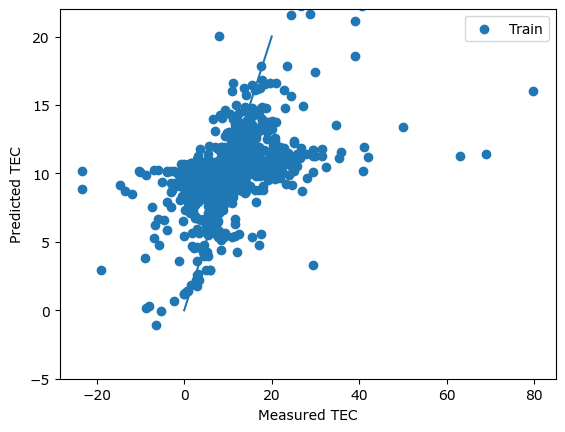

R2 Score:  0.22924976092768534


In [74]:
# Prediction for train set
y_train = torch.cat([y[i] for i in train_index])
X_train = [X[i] for i in train_index]
X_struc_train = [X_struc[i] for i in train_index]
y_pred_train = []
for x, x_struc in zip(X_train, X_struc_train):
    if torch.cuda.is_available():
        x, x_struc = x.to('cuda'), x_struc.to('cuda')
    y_pred_train.append(tec_model(x, x_struc).cpu())
y_pred_train = torch.cat(y_pred_train)

# Transform back
y_measure_train = (y_train*y_std)+y_mean
y_pred_train = (y_pred_train*y_std)+y_mean

# Plot data
plt.scatter(y_measure_train.numpy(), y_pred_train.detach().numpy())
plt.legend(["Train", "Test"])
plt.xlabel("Measured TEC")
plt.ylabel("Predicted TEC")
plt.plot([0, 20], [0, 20])
plt.ylim([-5, 22])
plt.savefig("figs/model_scatter_train.png")
plt.show()

print("R2 Score: ", r2_score(y_measure_train.numpy(), y_pred_train.detach().numpy()))

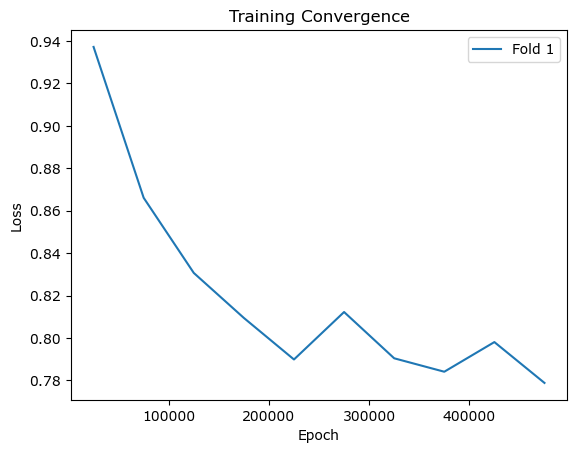

In [75]:
# Graph the Loss after each set of Batches 
k_smooth = 10
loss_log = np.array(loss_log)
smoothed_loss = []
avg_epoch = []
n_smooth = int(max(loss_log.shape)/k_smooth) - 1
for i in range(k_smooth):
    smoothed_loss.append(np.mean(loss_log[:, i*n_smooth:(i+1)*n_smooth], axis=1))
    avg_epoch.append((i+0.5)*n_smooth)
smoothed_loss = np.array(smoothed_loss)

plt.plot(avg_epoch, smoothed_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Convergence')
plt.legend(['Fold {}'.format(i) for i in range(1,n_splits+1)])
plt.savefig("figs/convergence_train.png")
plt.show()